This is another tutorial post, this time looking at editing molecules: adding and removing atoms and bonds.


In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import rdkit
print(rdkit.__version__)

2024.09.4


In [2]:
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 300,300

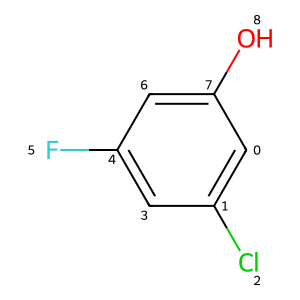

In [3]:
m = Chem.MolFromSmiles('c1c(Cl)cc(F)cc1O')
m

## Removing atoms and bonds

If we want to add or remove atoms and bonds we construct an `RWMol` (a Read/Write molecule) and then call `RemoveAtom()`:

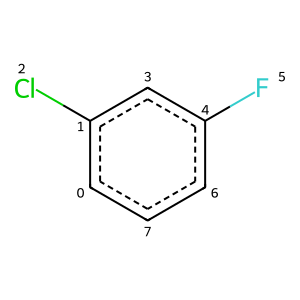

In [4]:
rwm = Chem.RWMol(m)
rwm.RemoveAtom(8)
rwm

To remove bonds, we provide the atom indices:

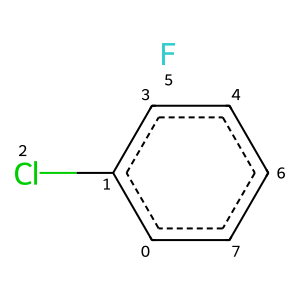

In [5]:
rwm.RemoveBond(4,5)
rwm

This is a bit awkward since atom numbers change when we remove atoms. We can see this by getting a new copy of the original molecule and removing atom 2:

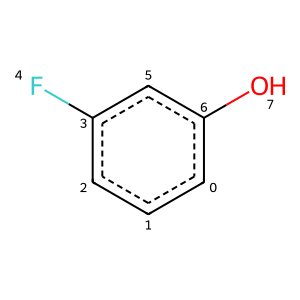

In [6]:
rwm = Chem.RWMol(m)
rwm.RemoveAtom(2)
rwm

Now the F is atom 7 instead of being atom 8 and atoms 4 and 5 are no longer connected (the bond we want is between atoms 3 and 4).

So when working this way, we need to be sure to remove the atoms in order of decreasing atomic index, and to remove bonds before we remove atoms. Otherwise we get errors or incorrect results:

In [7]:
rwm.RemoveAtom(8)

[05:24:31] 

****
Range Error
idx
Violation occurred on line 209 in file /home/conda/feedstock_root/build_artifacts/rdkit-meta_1736094075412/work/Code/GraphMol/ROMol.cpp
Failed Expression: 8 < 8
----------
Stacktrace:
 0# Invar::Invariant::toString[abi:cxx11]() const in /home/glandrum/mambaforge/envs/rdkit_blog/lib/python3.12/site-packages/rdkit/../../../libRDKitRDGeneral.so.1
 1# Invar::operator<<(std::ostream&, Invar::Invariant const&) in /home/glandrum/mambaforge/envs/rdkit_blog/lib/python3.12/site-packages/rdkit/../../../libRDKitRDGeneral.so.1
 2# RDKit::ROMol::getAtomWithIdx(unsigned int) in /home/glandrum/mambaforge/envs/rdkit_blog/lib/python3.12/site-packages/rdkit/Chem/../../../../libRDKitGraphMol.so.1
 3# RDKit::RWMol::removeAtom(unsigned int) in /home/glandrum/mambaforge/envs/rdkit_blog/lib/python3.12/site-packages/rdkit/Chem/../../../../libRDKitGraphMol.so.1
 4# 0x0000735214F7531E in /home/glandrum/mambaforge/envs/rdkit_blog/lib/python3.12/site-packages/rdkit/Chem/rdchem.so


RuntimeError: Range Error
	idx
	Violation occurred on line 209 in file Code/GraphMol/ROMol.cpp
	Failed Expression: 8 < 8
	RDKIT: 2024.09.4
	BOOST: 


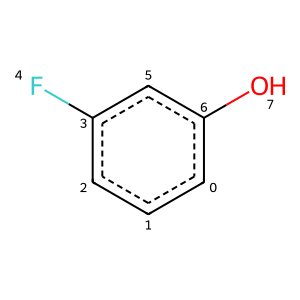

In [8]:
rwm.RemoveBond(4,5)  # nothing happens since there is no bond to remove
rwm

Since that's all kind of a pain, a few years ago we added functionality to allow you to batch the removal of atoms and bonds. The atoms and bonds are not removed until the batch is finished:

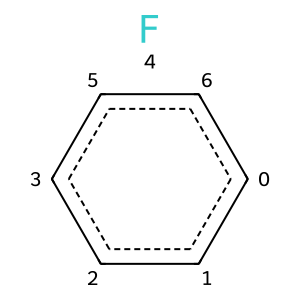

In [9]:
rwm = Chem.RWMol(m)
rwm.BeginBatchEdit() # start a batch
rwm.RemoveAtom(2)
rwm.RemoveAtom(8)
rwm.RemoveBond(4,5)
rwm.CommitBatchEdit()  # finish the batch
rwm

This has the added benefit of being a bit faster.

Finally, when we are done modifying the molecule, we can easily convert back to standard RDKit molecule:

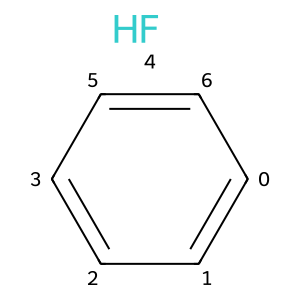

In [10]:
m2 = rwm.GetMol()
Chem.SanitizeMol(m2)
m2

## Adding atoms and bonds

Here's there's no equivalent of batch editing, but it's less important

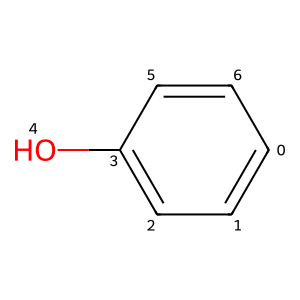

In [11]:
m = Chem.MolFromSmiles('c1ccc(O)cc1')
m

In [12]:
rwm = Chem.RWMol(m)

rwm.AddAtom(Chem.Atom(6))

7

That's the new atom index, which we can directly use:

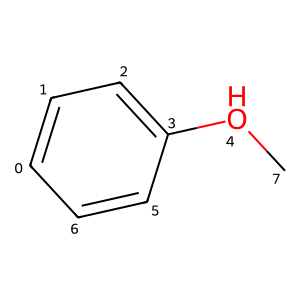

In [13]:
rwm.AddBond(4,7,Chem.BondType.SINGLE)
rwm

Notice that the chemistry is wrong here (it's still showing an implicit H on the O), but sanitization will clear this up:

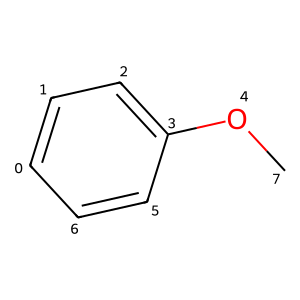

In [14]:
m2 = rwm.GetMol()
Chem.SanitizeMol(m2)
m2

# Replacing atoms and bonds

This is an easy onea

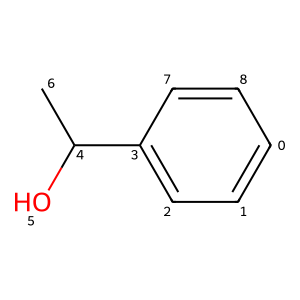

In [15]:
m = Chem.MolFromSmiles('c1ccc(C(O)C)cc1')
m

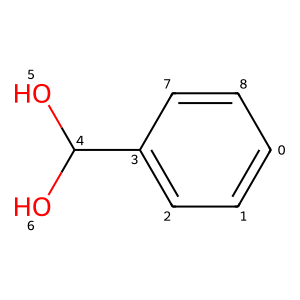

In [16]:
rwm = Chem.RWMol(m)
rwm.ReplaceAtom(6,Chem.Atom(8))
rwm

`ReplaceBond()` is marginally trickier since, for technical reasons, it's not possible to directly construct a bond in Python:

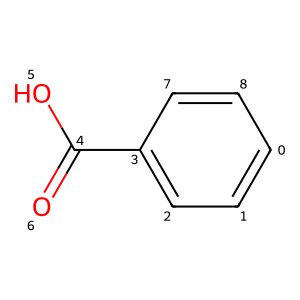

In [17]:
tempMol = Chem.MolFromSmiles("C=C")
bnd = tempMol.GetBondWithIdx(0)

rwm.ReplaceBond(rwm.GetBondBetweenAtoms(4,6).GetIdx(),bnd)
rwm

## Some gotchas

The most likely way to end up with molecules that are in an unhappy state, even though you've done (mostly) everything right, involve aromatic heteroatoms. This will come as no surprise if you've spent much time working with chemistry in the computer.

Here's an example:

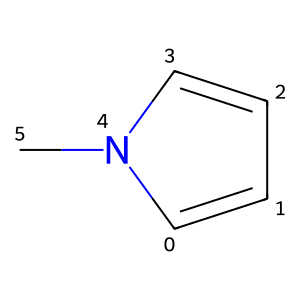

In [18]:
m = Chem.MolFromSmiles('c1cccn1C')
m

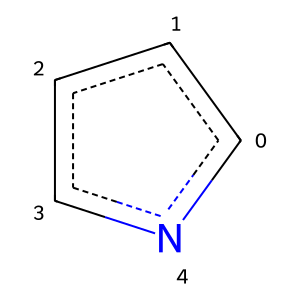

In [19]:
rwm = Chem.RWMol(m)
rwm.BeginBatchEdit()
rwm.RemoveAtom(5)
rwm.CommitBatchEdit()
rwm

That looks ok, but we can't sanitize it:

In [20]:
m2 = rwm.GetMol()
Chem.SanitizeMol(m2)

[05:24:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4


KekulizeException: Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4

This fails because we removed a bond from the aromatic N without updating its implicit H count. 
We can fix that:

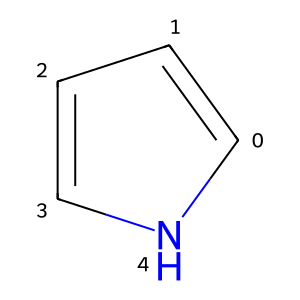

In [21]:
at = rwm.GetAtomWithIdx(4) 
at.SetNoImplicit(True)
at.SetNumExplicitHs(1)

m2 = rwm.GetMol()
Chem.SanitizeMol(m2)
m2

A similar problem happens when we add bonds to aromatic heteroatoms:

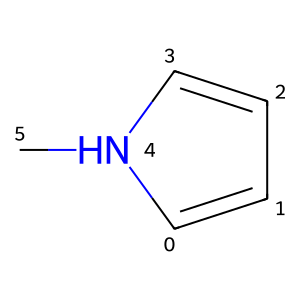

In [22]:
rwm = Chem.RWMol(m2)
aid = rwm.AddAtom(Chem.Atom(6))
rwm.AddBond(4,aid,Chem.BondType.SINGLE)
rwm

In [23]:
m3 = rwm.GetMol()
Chem.SanitizeMol(m3)

[05:24:38] Explicit valence for atom # 4 N, 5, is greater than permitted


AtomValenceException: Explicit valence for atom # 4 N, 5, is greater than permitted

The fix, once again, is to update the implicit H parameters on the aromatic heteroatom:

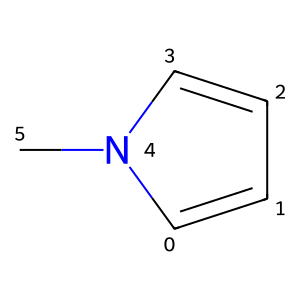

In [24]:
rwm = Chem.RWMol(m2)
aid = rwm.AddAtom(Chem.Atom(6))
rwm.AddBond(4,aid,Chem.BondType.SINGLE)
at = rwm.GetAtomWithIdx(4)
at.SetNumExplicitHs(0)
at.SetNoImplicit(False)
rwm

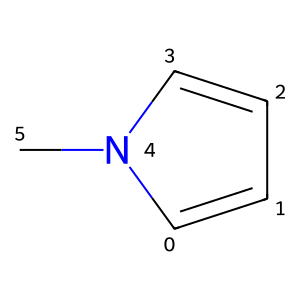

In [25]:
m3 = rwm.GetMol()
Chem.SanitizeMol(m3)
m3

As usual, I hope this was useful.